In [ ]:
# The Julia boostrap block
# This should be run for the first time to install Julia kernel, and then refresh this page (e.g., Ctrl-R)
# so that colab will redirect to the installed Julia kernel
# and then doing your own work

# 1. install latest Julia using jill.py
#    tip: one can install specific Julia version using e.g., `jill install 1.7`
!pip install jill && jill install --upstream Official --confirm
# 2. install IJulia kernel
! julia -e 'using Pkg; pkg"add IJulia, DiffEqOperators, PyPlot"; using IJulia; installkernel("Julia")'
# 3. hot-fix patch to strip the version suffix of the installed kernel so that this notebook kernelspec is version agnostic
!jupyter kernelspec install $(jupyter kernelspec list | grep julia | tr -s ' ' | cut -d' ' -f3) --replace --name julia

In [1]:
using DiffEqOperators
using PyPlot
using SparseArrays

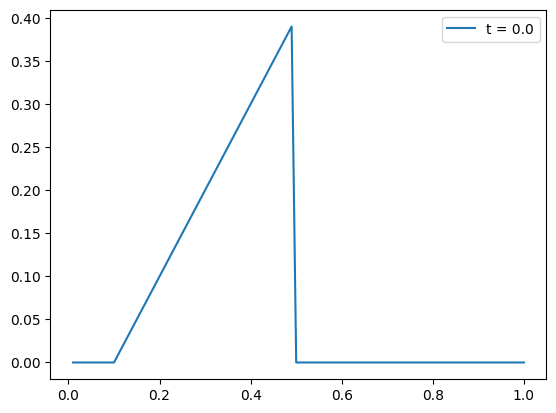

PyObject <matplotlib.legend.Legend object at 0x7f2756891c90>

In [3]:
# first order equation
# ∂ₜu + a∂ₓu = 0
# u(0,x) = ((x > 0.1) && (x < 0.5)) ? x-0.1 : 0.0

Δx = 0.01
x = Δx:Δx:1.0 |> Vector
N = length(x)
ord_deriv = 1
ord_approx = 2
a = 100
dt = 0.0001 # CFL: |aΔt/Δx| ≤ 1
Nt = 30
u0 = map(x -> ((x > 0.1) && (x < 0.5)) ? x-0.1 : 0.0, x)
plot(x, u0, label = "t = 0.0")
legend()

In [4]:
# efficient way to build fast lazy finite differences operators
# check more in http://diffeqoperators.sciml.ai/stable/operators/derivative_operators/
D = CenteredDifference(ord_deriv, ord_approx, Δx, N)
bc = PeriodicBC(Float64)
D = sparse(D*bc)[1]
Matrix(D)

100×100 Matrix{Float64}:
   0.0   50.0    0.0    0.0    0.0  …    0.0    0.0    0.0    0.0  -50.0
 -50.0    0.0   50.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0  -50.0    0.0   50.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0  -50.0    0.0   50.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0  -50.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0  -50.0  …    0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0  …    0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   ⋮                      

In [5]:
# solve PDE with explicit method and CenteredDifference
U = zeros(N,Nt)
U[:,1] = copy(u0)
for i in 2:Nt
    U[:,i] = U[:,i-1] - (dt * a) .* (D * U[:,i-1])
end

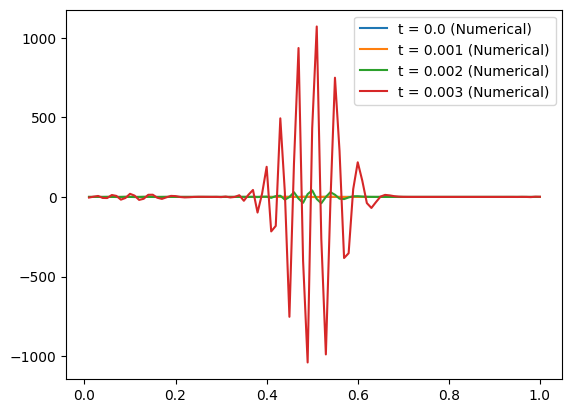

PyObject <matplotlib.legend.Legend object at 0x7f2756391110>

In [6]:
plot(x, U[:,1], label = "t = 0.0 (Numerical)")
plot(x, U[:,10], label = "t = $(dt * 10) (Numerical)")
plot(x, U[:,20], label = "t = $(dt * 20) (Numerical)")
plot(x, U[:,Nt], label = "t = $(dt * Nt) (Numerical)")
legend()
# unstable

In [7]:
# Lets try upwind scheme
# Du = (u_{j} - u_{j-1})/Δx when a > 0
# Du = (u_{j+1} - u_{j})/Δx when a < 0

# in UpwindDifference, they write equation like du/dt = b*f(du,u,x,t), 
# b is the last argument of function, so in this case,
# if we write equation like ∂ₜu + Du = 0, b should be -1
D = UpwindDifference(ord_deriv, 1, Δx, N, -1)
D = -1 .* sparse(D*bc)[1]
Matrix(D) # u_{j} - u_{j-1}

100×100 Matrix{Float64}:
  100.0     0.0     0.0     0.0     0.0  …     0.0     0.0     0.0  -100.0
 -100.0   100.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0  -100.0   100.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0  -100.0   100.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0  -100.0   100.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0  -100.0  …     0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0  …     0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0


In [8]:
U = zeros(N,Nt)
U[:,1] = copy(u0)
for i in 2:Nt
    U[:,i] = U[:,i-1] - (dt * a) .* (D * U[:,i-1])
end

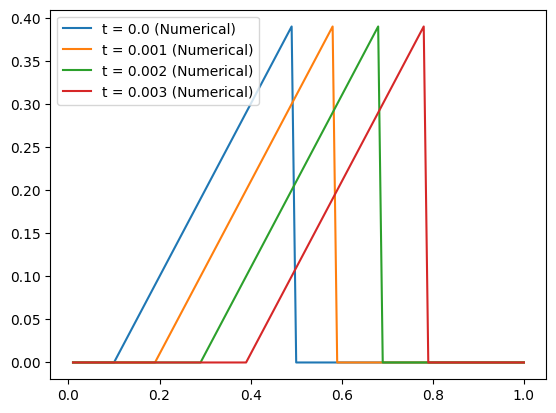

PyObject <matplotlib.legend.Legend object at 0x7f2756320590>

In [9]:
plot(x, U[:,1], label = "t = 0.0 (Numerical)")
plot(x, U[:,10], label = "t = $(dt * 10) (Numerical)")
plot(x, U[:,20], label = "t = $(dt * 20) (Numerical)")
plot(x, U[:,Nt], label = "t = $(dt * Nt) (Numerical)")
legend()
# just like a wave moves from left to right with speed a